# Registration

#### Register two MRI scans from different patients

In [1]:
import SimpleITK as sitk
import os
OUTPUT_DIR = 'Output'

## Utility Functions

In [2]:
from vizhelpercode import *

## Load the images

We load the images directly from CEDAR remote mounted file system. 

In [3]:
fixed_image = sitk.ReadImage('/local-scratch/cedar-rm/scratch/asa224/Datasets/BRATS2017/MICCAI_BraTS17_Data_Training/HGG/Brats17_2013_10_1/Brats17_2013_10_1_t1.nii.gz', sitk.sitkFloat32)

In [4]:
moving_image = sitk.ReadImage('/local-scratch/cedar-rm/scratch/asa224/Datasets/BRATS2017/MICCAI_BraTS17_Data_Training/HGG/Brats17_CBICA_AQY_1/Brats17_CBICA_AQY_1_t1.nii.gz', sitk.sitkFloat32)

3D Image detected, showing only the middle slice..


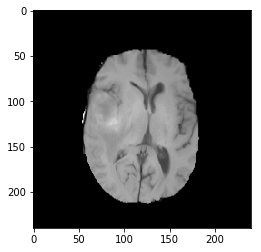

In [5]:
showMPL(fixed_image)

3D Image detected, showing only the middle slice..


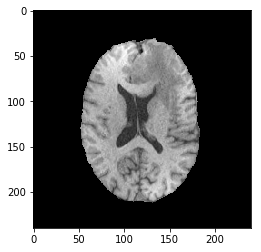

In [6]:
showMPL(moving_image)

In [7]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), 
         moving_image_z=(0,moving_image.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), 
         moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)), continuous_update=False)

interactive(children=(IntSlider(value=77, description=u'fixed_image_z', max=154), IntSlider(value=77, description=u'moving_image_z', max=154), Output()), _dom_classes=('widget-interact',))

<function vizhelpercode.display_images>

## Perform initial registration by just mergin the centers of two images together

#### CenteredTransformInitializer

This class is connected to the fixed image, moving image and transform involved in the registration. Two modes of operation are possible:

Geometrical,
Center of mass
In the first mode, the geometrical center of the moving image is passed as initial center of rotation to the transform and the vector from the center of the fixed image to the center of the moving image is passed as the initial translation. This mode basically assumes that the anatomical objects to be registered are centered in their respective images. Hence the best initial guess for the registration is the one that superimposes those two centers.

In the second mode, the moments of gray level values are computed for both images. The center of mass of the moving image is then used as center of rotation. The vector between the two centers of mass is passes as the initial translation to the transform. This second approach assumes that the moments of the anatomical objects are similar for both images and hence the best initial guess for registration is to superimpose both mass centers. Note that this assumption will probably not hold in multi-modality registration.

In [13]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [ ]:
import vizhelpercode

In [ ]:
reload(vizhelpercode)
from vizhelpercode import display_images_with_alpha_old

In [14]:
# we run the Resample function to perform the transformation on the moving image, where the transformation is an output
# from a transformation function (translation, rotation, scaling, sheering etc.)
moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha_old, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=77, description=u'image_z', max=155), FloatSlider(value=0.5, description=u'alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<function vizhelpercode.display_images_with_alpha_old>

In [12]:
# we run the Resample function to perform the transformation on the moving image, where the transformation is an output
# from a transformation function (translation, rotation, scaling, sheering etc.)
moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha_old, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=77, description=u'image_z', max=155), FloatSlider(value=0.5, description=u'alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<function vizhelpercode.display_images_with_alpha_old>

## Build the registration pipeline

In [ ]:
help(sitk.ImageRegistrationMethod)

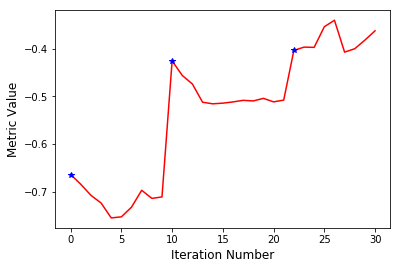

In [15]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
# registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=10)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [16]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.381563832375
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [17]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha_old, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=77, description=u'image_z', max=155), FloatSlider(value=0.5, description=u'alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

In [19]:
sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, 'RIRE_training_001_mr_T1_resampled.nii.gz'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))

## Compare with how they were originally

In [ ]:
interact(display_images_with_alpha_old, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_image));